In [1]:
import xgboost as xgb
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance#, plot_partial_dependence
import numpy as np
import shap
from BO_utility import *

In [2]:
csv_path = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'datasets',
    'quality_scores.csv'
))


df = pd.read_csv(csv_path)
df

,Experiment,Index,Param1,Param2,Param3,Param4,Area sum,BLOBs,Area mean,Area std,Roundness mean,Roundness std,Perimeter mean,Perimeter std
0,1,0,0.25,60,2.0,220,11918,21,8772.619048,21908.516714,0.649918,0.353319,499.641926,901.684578
1,1,1,0.25,60,2.0,220,9683,26,6073.153846,18251.895583,0.683206,0.329328,447.331256,1082.563365
2,1,2,0.25,60,2.0,220,11782,17,10383.058824,26157.197501,0.827485,0.145331,600.045280,1355.544781
3,1,3,0.25,60,2.0,220,10429,37,4370.270270,16512.123672,0.626778,0.321378,306.210493,958.794762
4,1,4,0.25,60,2.0,220,11741,16,10986.125000,27015.461242,0.821640,0.128586,686.211823,1604.091451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,4,5,1.10,60,2.0,220,988,17,159.470588,142.859502,0.697754,0.307941,50.234106,31.134514
1194,4,6,1.10,60,2.0,220,1534,20,395.850000,889.535231,0.689979,0.282397,71.986710,78.768972
1195,4,7,1.10,60,2.0,220,1162,21,166.428571,279.034828,0.680360,0.185070,47.104769,40.598457
1196,4,8,1.10,60,2.0,220,2334,36,523.972222,2173.883871,0.695035,0.308996,78.531934,159.118691


In [3]:
param_df = df[["Param1", "Param2", "Param3", "Param4"]]
target_df = df[["Area sum"]]

standard_param = ( param_df - param_df.mean() ) / (param_df.std() + 1e-8)
standard_target = ( target_df - target_df.mean() ) / (target_df.std() + 1e-8)

df_standard = pd.concat([standard_param, standard_target], axis=1)
df_normal = pd.concat([param_df, target_df], axis=1)

corr_matrix = df_normal.corr() #df_standard.corr()
corr_matrix*100 # Param1 and Area sum are highly correlated

,Param1,Param2,Param3,Param4,Area sum
Param1,100.000000,9.578688,7.045045,-15.301177,-13.603488
Param2,9.578688,100.000000,2.489988,14.908166,-24.495101
Param3,7.045045,2.489988,100.000000,-1.781105,-6.297916
Param4,-15.301177,14.908166,-1.781105,100.000000,-22.160489
Area sum,-13.603488,-24.495101,-6.297916,-22.160489,100.000000


In [4]:
X = df[["Param1", "Param2", "Param3", "Param4"]]
y = df["Area sum"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [5]:
import pickle
#pickle.dump(grid_search, open("grid_search.pkl", "wb"))
#pickle.dump(best_model, open("best_model.pkl", "wb"))

# (XGBoost==1.6.2)
model = pickle.load(open("best_model.pkl", "rb"))

# (sklearn==1.2.0)
grid_search = pickle.load(open("grid_search.pkl", "rb"))

In [6]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# Shap

In [91]:
shap.initjs()
index = 1
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

In [93]:
print(X_test.iloc[index])
print(y_test.iloc[index])

Param1     1.1
Param2    40.0
Param3     2.0
Param4    75.0
Name: 1014, dtype: float64
4481


In [103]:
print(shap_values[index].values.sum()+shap_values.base_values[0])

4484.211683501682


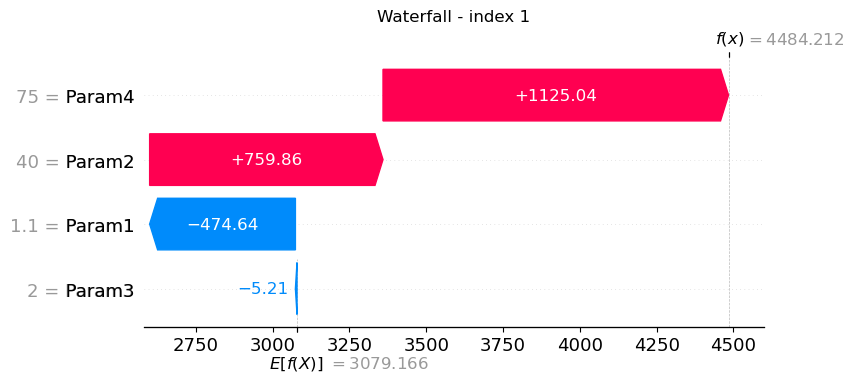

In [110]:
plt.title(f"Waterfall - index {index}")
shap.plots.waterfall(shap_values[index])

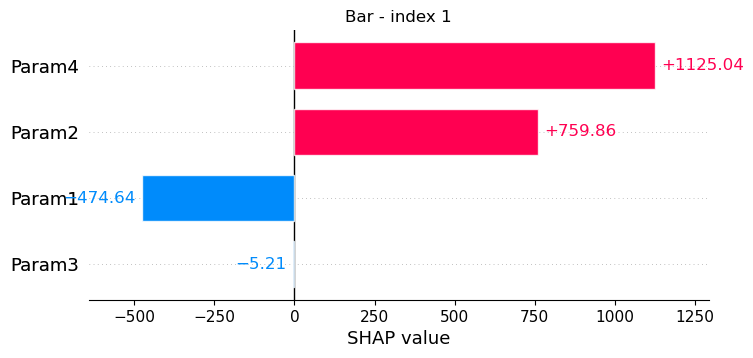

In [111]:
plt.title(f"Bar - index {index}")
shap.plots.bar(shap_values[index])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


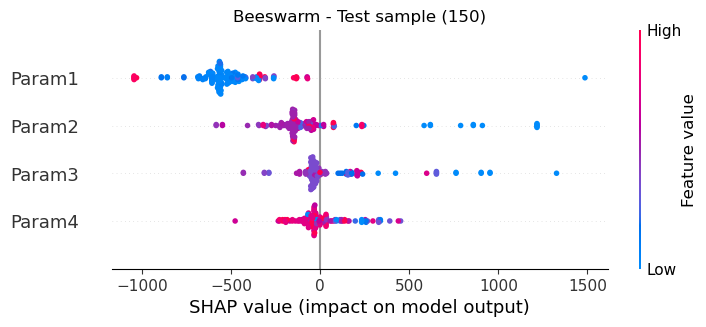

In [112]:
plt.title("Beeswarm - Test sample (150)")
shap.plots.beeswarm(shap_values.sample(150))

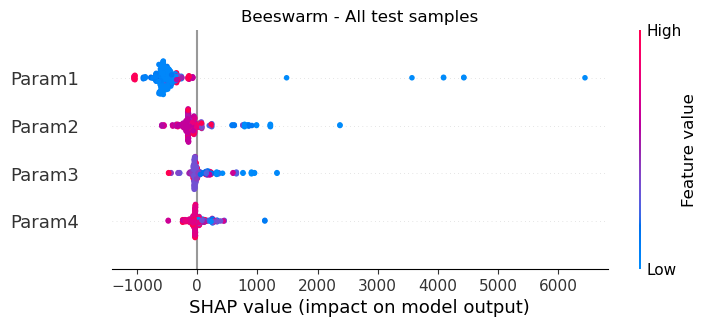

In [114]:
plt.title("Beeswarm - All test samples")
shap.plots.beeswarm(shap_values)

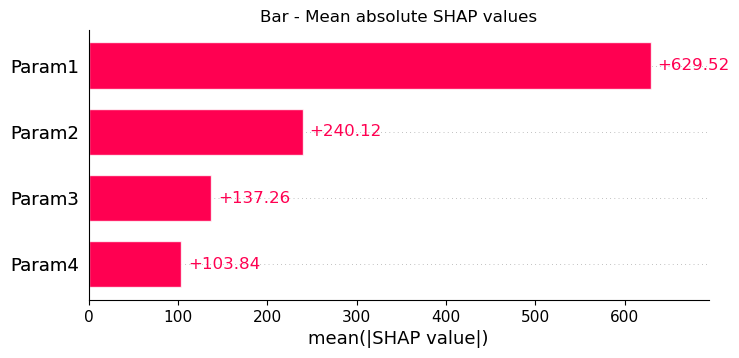

In [118]:
plt.title("Bar - Mean absolute SHAP values")
shap.plots.bar(shap_values)

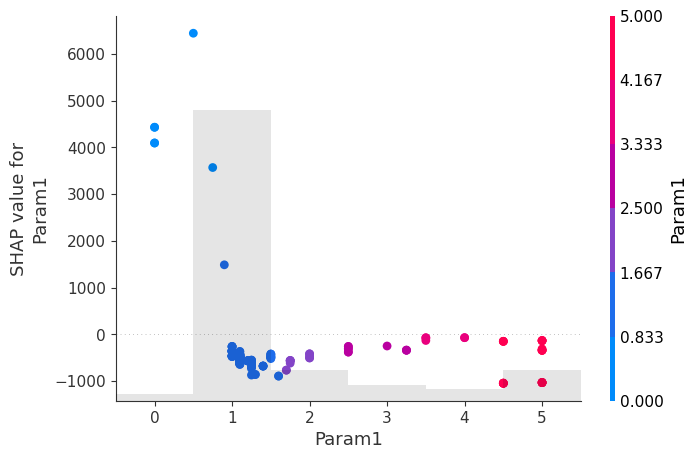

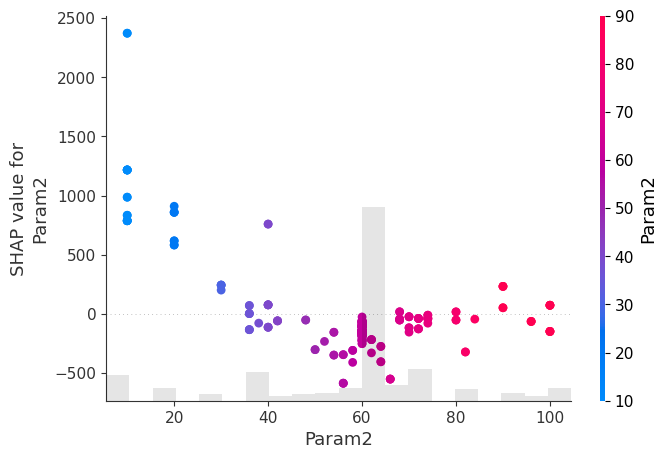

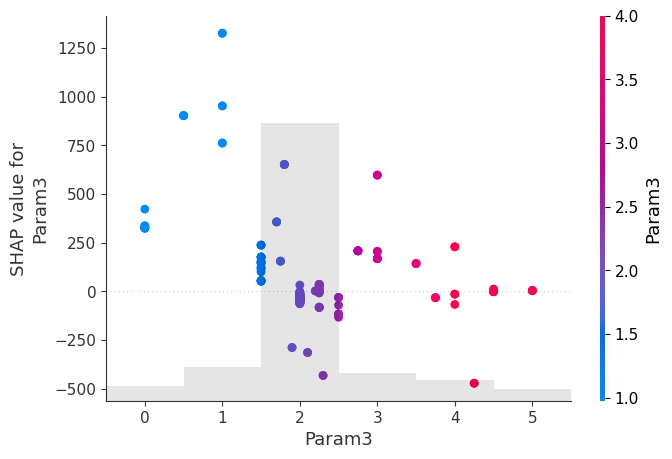

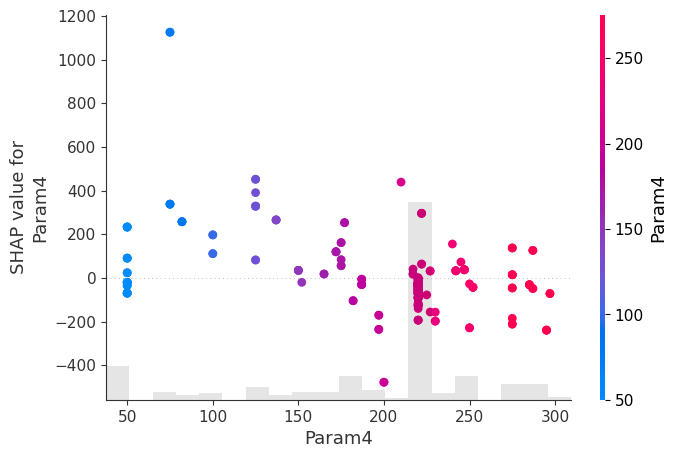

In [145]:
for i in range(1,5):
    shap.plots.scatter(shap_values[:, "Param"+str(i)], shap_values[:, "Param"+str(i)], dot_size=40, alpha=1)
    plt.show()

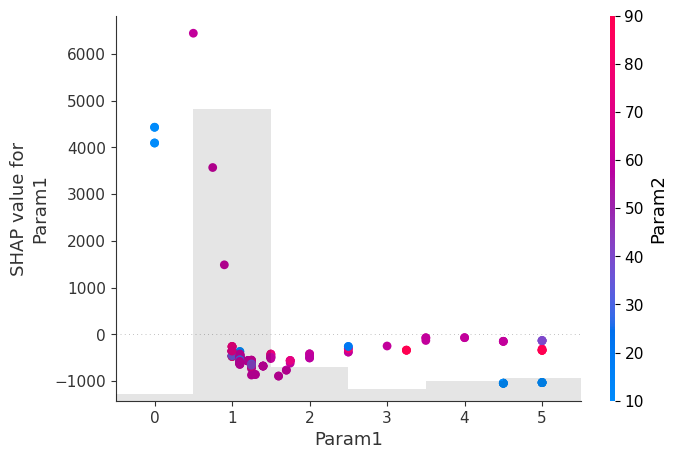

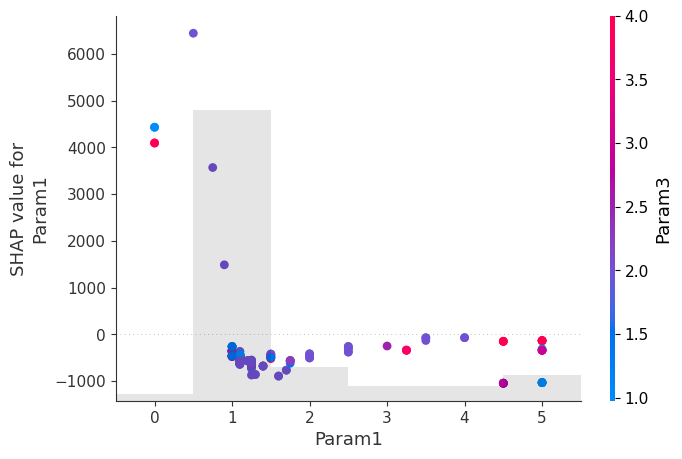

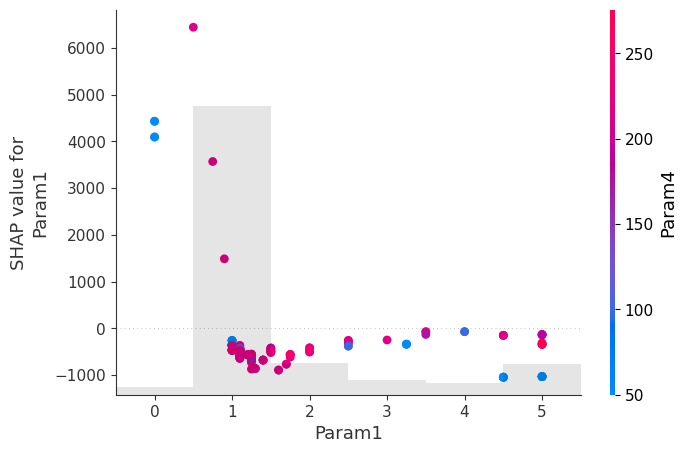

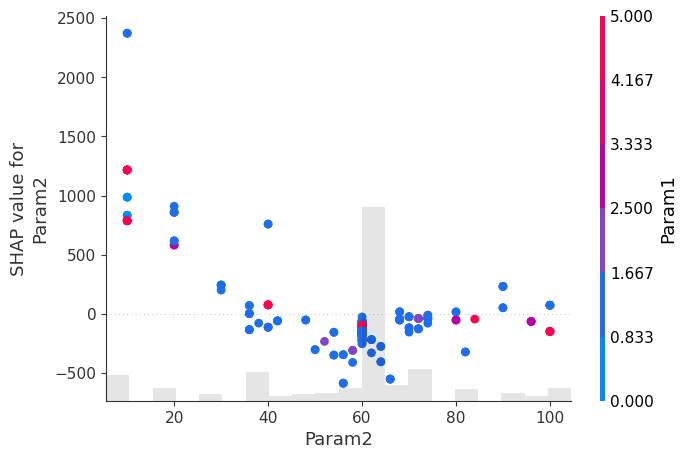

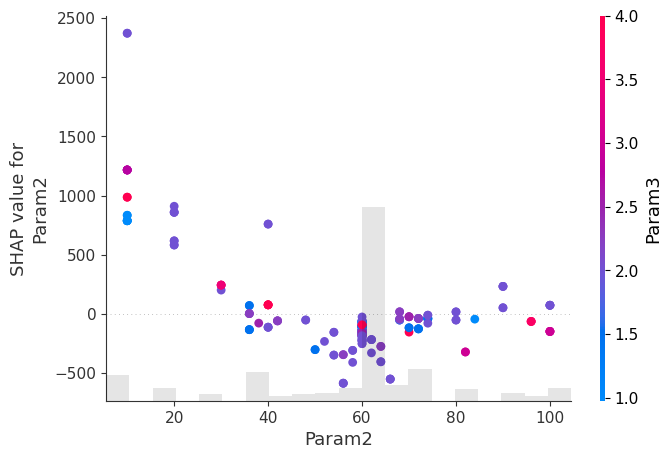

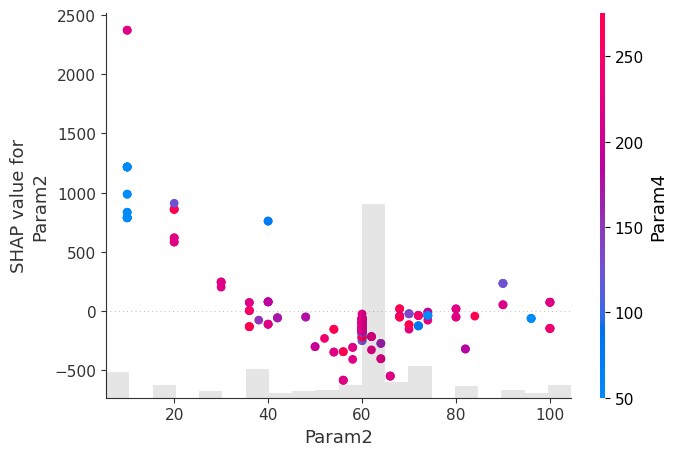

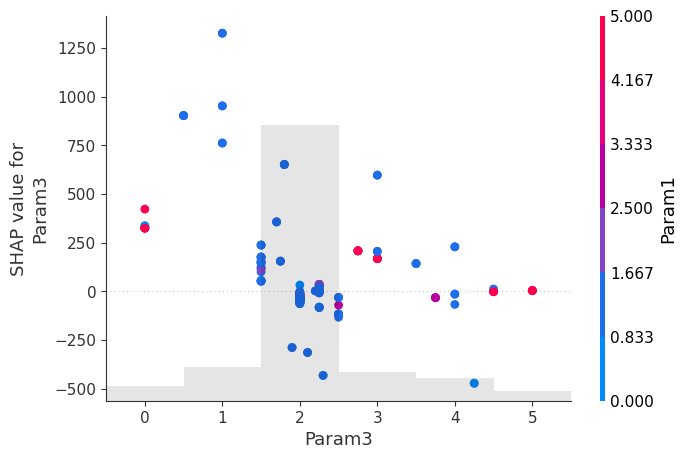

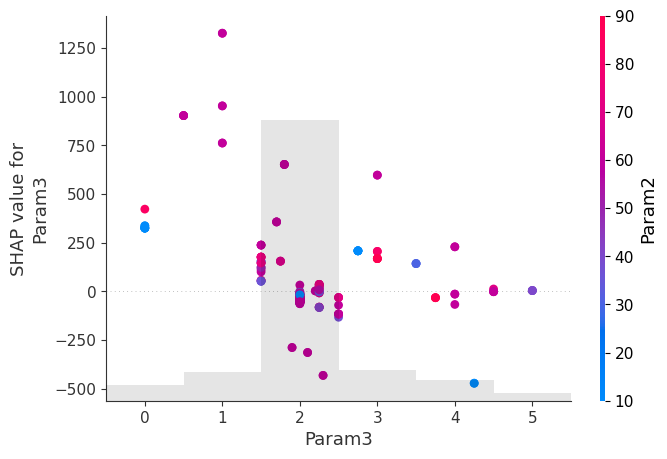

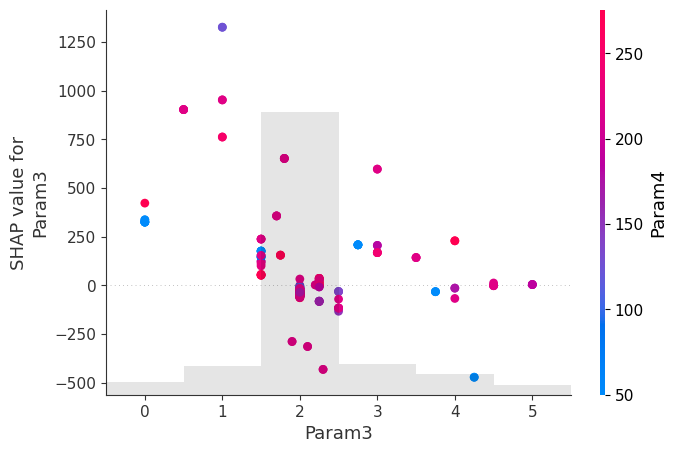

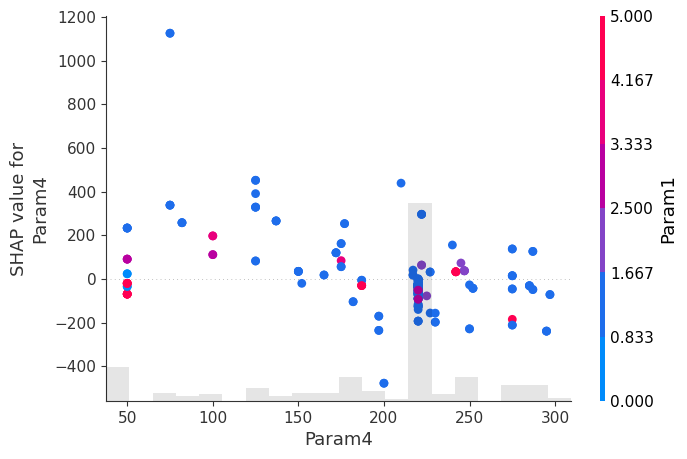

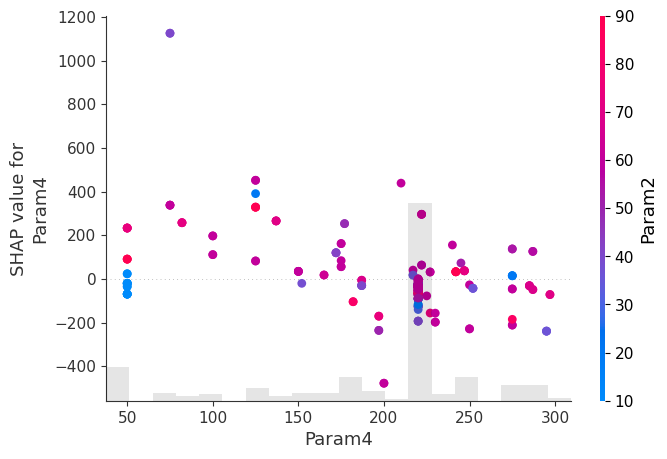

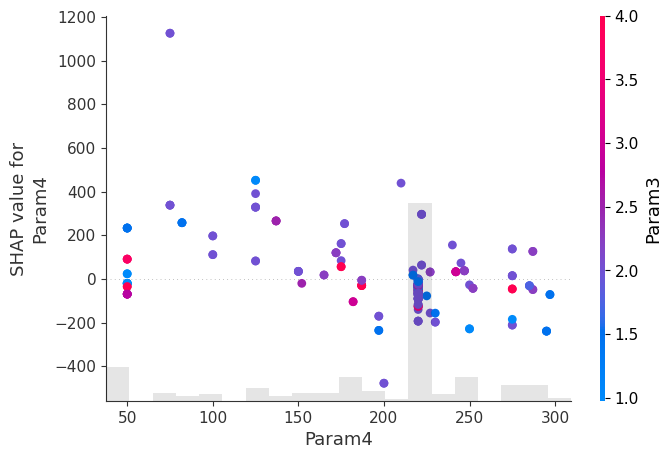

In [127]:
for i in range(1,5):
    for j in range(1,5):
        if j == i:
            continue
        shap.plots.scatter(shap_values[:, "Param"+str(i)], color=shap_values[:,"Param"+str(j)], dot_size=40, alpha=1)
        plt.show()